# Comparing lineage-associated gene rankings

Notebook compares the performance of different methods for ranking lineage-associated genes.

## Library imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import (
    get_aucs,
    get_gene_ranks,
    get_optimal_auc,
    get_rank_threshold,
    get_var_ranks,
    plot_gene_ranking,
)
from rgv_tools.core import METHOD_PALETTE_RANKING

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "hematopoiesis"

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [4]:
TERMINAL_STATES = ["Ery", "Mon"]

## Data loading

In [5]:
drivers_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / "rgv_ranking.csv", index_col=0)
drivers_scv = pd.read_csv(DATA_DIR / DATASET / "results" / "scv_ranking.csv", index_col=0)
drivers_vi = pd.read_csv(DATA_DIR / DATASET / "results" / "vi_ranking.csv", index_col=0)

Load ground truth

In [6]:
Ery_g = pd.read_csv(DATA_DIR / DATASET / "raw" / "Ery_lineage_associated_genes.csv", index_col=0).iloc[:, 0]
Mon_g = pd.read_csv(DATA_DIR / DATASET / "raw" / "Mon_lineage_associated_genes.csv", index_col=0).iloc[:, 0]

## Ranking

In [7]:
terminal_states = ["Ery", "Mon"]
for terminal_state in TERMINAL_STATES:
    drivers_rgv = drivers_rgv.merge(
        pd.DataFrame(drivers_rgv.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

    drivers_scv = drivers_scv.merge(
        pd.DataFrame(drivers_scv.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

    drivers_vi = drivers_vi.merge(
        pd.DataFrame(drivers_vi.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

In [8]:
Ery_g = list(set(Ery_g).intersection(drivers_scv.index.tolist()))
Mon_g = list(set(Mon_g).intersection(drivers_scv.index.tolist()))

In [9]:
gene_ranks_rgv = {terminal_state: pd.DataFrame() for terminal_state in TERMINAL_STATES}

## load Ery
_df = get_var_ranks(var_names=Ery_g, drivers=drivers_rgv, macrostate="Ery", var_type="Driver", model="RegVelo")
gene_ranks_rgv["Ery"] = pd.concat([gene_ranks_rgv["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_g, drivers=drivers_rgv, macrostate="Mon", var_type="Driver", model="RegVelo")
gene_ranks_rgv["Mon"] = pd.concat([gene_ranks_rgv["Mon"], _df])

Driver towards Ery for RegVelo in top 100: 17 (out of 65)
Driver towards Mon for RegVelo in top 100: 4 (out of 26)


In [10]:
for terminal_state in gene_ranks_rgv.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_rgv[terminal_state] = gene_ranks_rgv[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = DATA_DIR / DATASET / "results" / f"gene_ranks_{terminal_state}-rgvelo.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_rgv[terminal_state].to_csv(output_path)

In [11]:
gene_ranks_scv = {terminal_state: pd.DataFrame() for terminal_state in TERMINAL_STATES}

## load Ery
_df = get_var_ranks(var_names=Ery_g, drivers=drivers_scv, macrostate="Ery", var_type="Driver", model="scVelo")
gene_ranks_scv["Ery"] = pd.concat([gene_ranks_scv["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_g, drivers=drivers_scv, macrostate="Mon", var_type="Driver", model="scVelo")
gene_ranks_scv["Mon"] = pd.concat([gene_ranks_scv["Mon"], _df])

Driver towards Ery for scVelo in top 100: 15 (out of 65)
Driver towards Mon for scVelo in top 100: 3 (out of 26)


In [12]:
for terminal_state in gene_ranks_scv.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_scv[terminal_state] = gene_ranks_scv[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = DATA_DIR / DATASET / "results" / f"gene_ranks_{terminal_state}-scVelo.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_scv[terminal_state].to_csv(output_path)

In [13]:
gene_ranks_vi = {terminal_state: pd.DataFrame() for terminal_state in TERMINAL_STATES}

## load Ery
_df = get_var_ranks(var_names=Ery_g, drivers=drivers_vi, macrostate="Ery", var_type="Driver", model="veloVI")
gene_ranks_vi["Ery"] = pd.concat([gene_ranks_vi["Ery"], _df])

## load Mon
_df = get_var_ranks(var_names=Mon_g, drivers=drivers_vi, macrostate="Mon", var_type="Driver", model="veloVI")
gene_ranks_vi["Mon"] = pd.concat([gene_ranks_vi["Mon"], _df])

Driver towards Ery for veloVI in top 100: 11 (out of 65)
Driver towards Mon for veloVI in top 100: 4 (out of 26)


In [14]:
for terminal_state in gene_ranks_vi.keys():
    # Sort the DataFrame for each terminal state
    gene_ranks_vi[terminal_state] = gene_ranks_vi[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    # Create the path for the output file
    output_path = DATA_DIR / DATASET / "results" / f"gene_ranks_{terminal_state}-veloVI.csv"
    # Save the sorted DataFrame to a CSV file, one for each terminal state
    gene_ranks_vi[terminal_state].to_csv(output_path)

In [15]:
gene_ranks = get_gene_ranks(TERMINAL_STATES, DATA_DIR, DATASET)

In [16]:
methods = {}
n_methods = {}

for terminal_state in TERMINAL_STATES:
    methods[terminal_state] = gene_ranks[terminal_state]["Algorithm"].unique().tolist()
    if "Run" in gene_ranks[terminal_state].columns:
        n_methods[terminal_state] = gene_ranks[terminal_state][["Algorithm", "Run"]].drop_duplicates().shape[0]
    else:
        n_methods[terminal_state] = len(methods[terminal_state])

In [17]:
dfs = get_rank_threshold(gene_ranks=gene_ranks, n_methods=n_methods, TERMINAL_STATES=TERMINAL_STATES)

In [18]:
pal = METHOD_PALETTE_RANKING

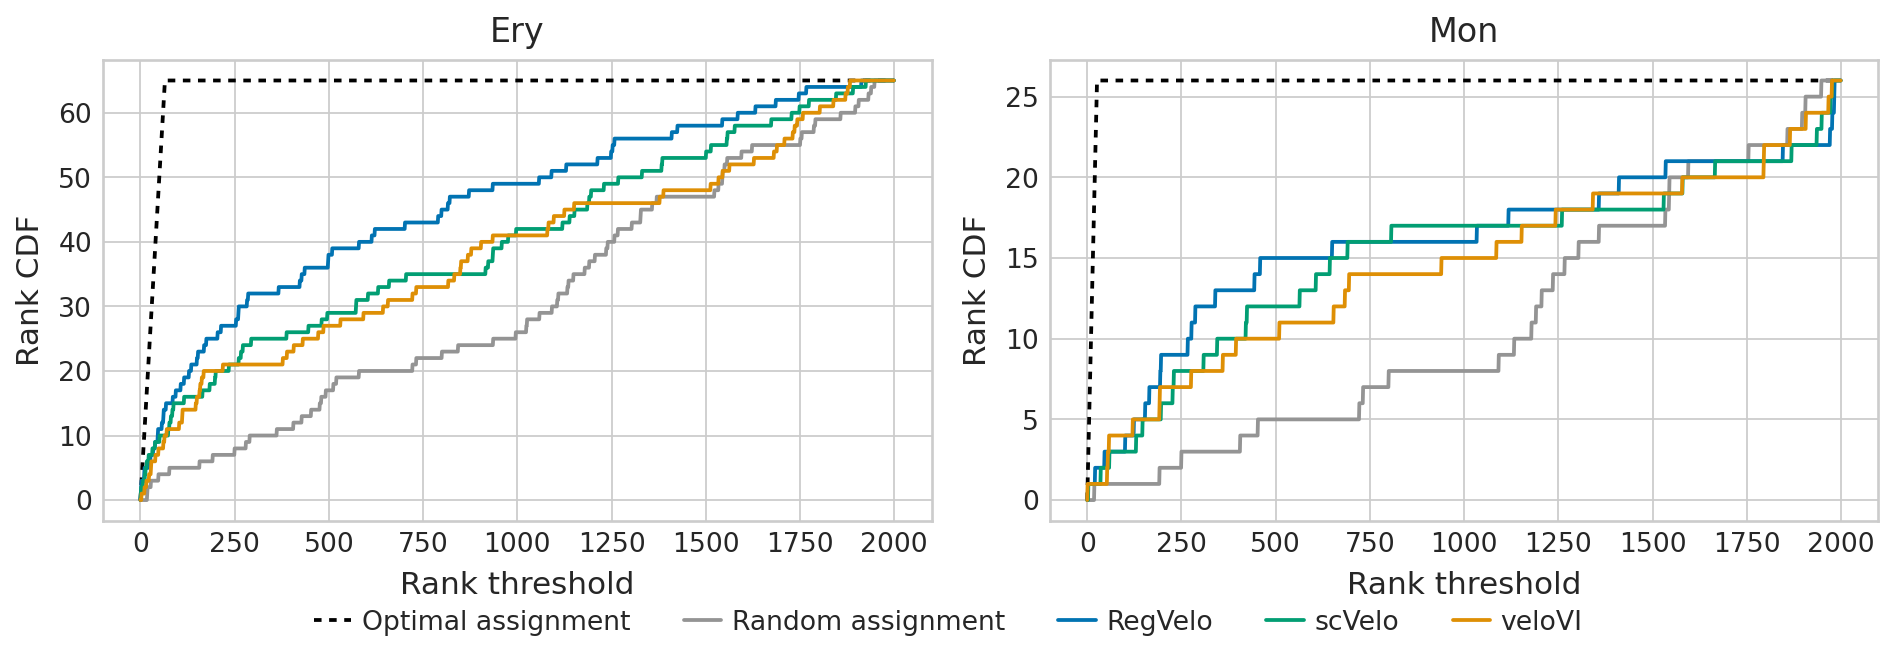

In [19]:
plot_gene_ranking(
    rank_threshold=dfs,
    methods=methods,
    palette=pal,
    TERMINAL_STATES=TERMINAL_STATES,
    path=FIG_DIR / DATASET / "Gene Ranking.svg",
    format="svg",
)

In [20]:
optimal_aucs = {}

for terminal_state in TERMINAL_STATES:
    if "Run" in gene_ranks[terminal_state].columns:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby(["Algorithm"]).size() / gene_ranks[
            terminal_state
        ].groupby(["Algorithm"]).apply(lambda x: len(x["Run"].unique()))
    else:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby("Algorithm").size()
    optimal_aucs[terminal_state] = get_optimal_auc(optimal_aucs[terminal_state])

In [21]:
_, auc_rel_df = get_aucs(
    gene_ranking_dfs=dfs, optimal_aucs=optimal_aucs, methods=methods, TERMINAL_STATES=TERMINAL_STATES
)
auc_rel_df

,Ery,Mon
scVelo,0.634002,0.588447
Optimal assignment,0.999238,0.999245
Random assignment,0.490443,0.423125
RegVelo,0.724887,0.620126
veloVI,0.604311,0.562961
